<a href="https://colab.research.google.com/github/ND15/Image-Processing/blob/main/Image_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [ ]:
def read_img(image_path):
    image = load_img(image_path)
    image = img_to_array(image)
    return image

In [ ]:
def pool_region(image, pad_h, pad_w, image_row, image_col):
    row, col = image.shape
    for i in range(pad_h, image_row + 1):
        for j in range(pad_w, image_col + 1):
            yield image[i - pad_h : i + pad_h + 1, j - pad_w : j + pad_w + 1], i, j

In [ ]:
def rotate_kernel(image):
    for i in range(int(image.shape[0] / 2)):
        for j in range(int(image.shape[1])):
            temp = image[i][j]
            image[i][j] = image[image.shape[0]-1-i][image.shape[1]-1-j]
            image[image.shape[0]-1-i][image.shape[1]-1-j] = temp
    j = 0
    while(j < int(image.shape[1]/2)):
        temp = image[int(image.shape[0]/2)][j] 
        image[int(image.shape[0]/2)][j] = image[int(image.shape[0] / 2)][int(image.shape[1]-j-1)]
        image[int(image.shape[0] / 2)][int(image.shape[1]-j-1)] = temp
        j += 1
    return image

In [ ]:
def convolution2D(image, kernel):
    row, col = image.shape
    output = np.zeros(image.shape)

    kernel_row, kernel_col = kernel.shape

    pad_h = int((kernel_row - 1) / 2)
    pad_w = int((kernel_col - 1) / 2)

    padded_image = np.zeros((row + (2*pad_h), col + (2 * pad_w)))
    padded_image[pad_h : row + pad_h, pad_w : col + pad_w] = image

    # for i in range(pad_h, row+1):
    #     for j in range(pad_w, col+1):
    #         output[i-1, j-1] = np.sum(kernel * padded_image[i - pad_h : i + pad_h + 1, 
    #                                                     j - pad_w : j + pad_w + 1])
    kernel = rotate_kernel(kernel)

    for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
        output[i-1, j-1] = np.sum(kernel * im_region)

    return output

(-0.5, 372.5, 372.5, -0.5)

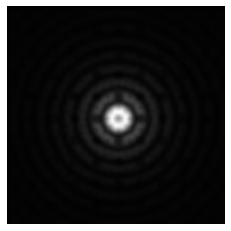

In [ ]:
image = read_img("download.png")
kernel = np.random.randint(1,5, (9, 9))
conv_img = convolution2D(image[...,1], kernel)
plt.imshow(conv_img, cmap="gray")
plt.axis('off')

(-0.5, 372.5, 372.5, -0.5)

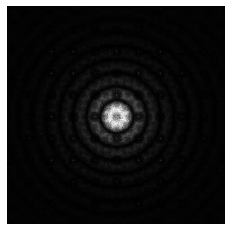

In [ ]:
plt.imshow(image[...,0], cmap="gray")
plt.axis('off')

In [ ]:
def mean_filter(image, kernel=(3, 3), filter_type="am", q=0):
    """
    Parameters
    ------------------
        image : image matrix
        kernel : kernel size
        filter_type : Type of the filter. It can be am, gm, hm, chm.
                      "am" : arithmetic filter
                      "gm" : geometric mean filter
                      "hm" : harmonic mean filter
                      "chm" : contra-harmonic filter
    ------------------
    """
    row, col = image.shape
    output = np.zeros(image.shape)

    kernel_row, kernel_col = kernel

    pad_h = int((kernel_row - 1) / 2)
    pad_w = int((kernel_col - 1) / 2)

    padded_image = np.zeros((row + (2*pad_h), col + (2 * pad_w)))
    padded_image[pad_h : row + pad_h, pad_w : col + pad_w] = image

    if filter_type == "am":
        print("Arithmetic Mean Filter\n")
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i-1, j-1] = (1 / (row * col)) * np.sum(im_region)
    
    elif filter_type == "gm":
        print("Geometric Mean Filter\n")
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i-1, j-1] = np.power(np.prod(im_region), (1 / (row * col)))
    
    elif filter_type == "hm":
        print("Harmonic Mean Filter\n")
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i-1, j-1] = (row * col) / np.sum( 1 / im_region)
            
    elif filter_type == "chm":
        print("Contraharmonic Mean Filter\n")
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i-1, j-1] = np.power(np.sum(im_region), q+1) / np.power(np.sum(im_region), q)
            
    return output

In [ ]:
def order_statistics_filter(image, kernel=(3, 3), filter_type="median", d=0):
    """
    Returns a modified image by applying the desired filter.
    
    Parameters
    ---------------
        image : image matrix
        
        kernel : Size of the kernel to be applied to the
                 image.
        
        filter_type : type of order statistics filter to be 
                      applied to the image.
                      "median" : median filter
                      "max" : max filter
                      "min" : min filter
                      "midpoint" : midpoint filter
                      "alpha_trim" : alpha trimmed filter
        d : value of d for the alpha trimmed filter
    ---------------
    """
    
    output = np.zeros(image.shape)
    
    row, col = image.shape
    kernel_row, kernel_col = kernel
    
    pad_h = int((kernel_row - 1) / 2)
    pad_w = int((kernel_row - 1) / 2)
    
    padded_image = np.zeros((row + (2*pad_h), col + (2 * pad_w)))
    padded_image[pad_h : row + pad_h, pad_w : col + pad_w] = image
    
    if filter_type == "median":
        
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            x = np.sort(np.reshape(im_region, (1, im_region.shape[0] * im_region.shape[1])), kind="quicksort")
            
            if x.shape[1] % 2 != 0:
                x_index = int(np.floor(x.shape[1] / 2))
                output[i-1, j-1] = x[0][x_index]
            else:
                x_index = int(x.shape[1] / 2)
                output[i-1, j-1] = (x[0][x_index-1] + x[0][x_index]) / 2
    
    elif filter_type == "max":
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i - 1, j - 1] = np.max(im_region)
    
    elif filter_type == "min":
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i - 1, j - 1] = np.min(im_region)
    
    elif filter_type == "midpoint":
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            output[i - 1, j - 1] = (1/2) * (np.max(im_region) + np.min(im_region))
        
    elif filter_type == "alpha_trimmed":
        for im_region, i, j in pool_region(padded_image, pad_h, pad_w, image.shape[0], image.shape[1]):
            x = np.sort(np.reshape(im_region, (1, im_region.shape[0] * im_region.shape[1])), kind="quicksort")
            x = x[0][int(d / 2) : x.shape[1] - int(d / 2)]
            output[i-1, j-1] = (1 / ((im_region.shape[0] * image.shape[1]) - 2)) * np.sum(x)
            
    return output